In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path = "/Users/atalianb/Documents/data_LBSG/Blok_McGaugh_& _Rubin_(2001)/"

In [3]:
ESO3020120 = np.loadtxt(path+'ESO3020120.dat')

In [4]:
vecRp_ESO3020120 = np.array([row[1] for row in ESO3020120])# galactocentric distance [kpc]
vecvRp_ESO3020120 = np.array([row[5] for row in ESO3020120])# rotation velocity [km/s]
vecerrvRp_ESO3020120 = np.array([row[6] for row in ESO3020120])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

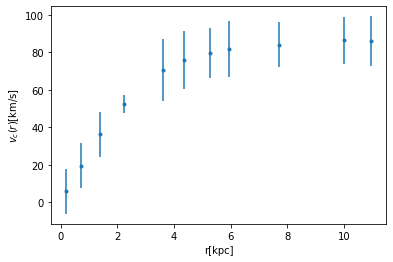

In [5]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [7]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
###l=1 
u1_1 = -3.7# 1st trial value of unknown init. cond.
u2_1 = -2.2# 2nd trial value of unknown init. cond.
u_1 = np.array([u1_1, u2_1])

In [8]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [9]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [10]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [11]:
def f1(x,y):
    l = 1.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [12]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [13]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [14]:
#The function integrate f0 with the shooting method,
#integrates to find the M(r) and returns the r[kpc] and Vc[km/s] 
#if the last element of r[kpc] array is minor than the last element of the r data array
#takes the last element of the M(r) array and compute the Vc^2 for the rest of the r elements
def Vc_xy(r,m_a,eps,l=1.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f1,u_1,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=1.)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [15]:
def Vc_xi2(r,m_a,eps,l=1.):
    Vc = Vc_xy(r,m_a,eps)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

# $\chi^{2}$

# ESO3020120

$\epsilon$

In [16]:
def Chi2_eps_ESO3020120(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_ESO3020120,m_a_,eps,l=1.)
    xi = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [17]:
x0_eps_ESO3020120 = np.array(np.log(1.0e-4))
LS_eps_ESO3020120 = optimize.minimize(Chi2_eps_ESO3020120,x0_eps_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps_ESO3020120)

      fun: 156.794791397851
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00108855])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([-8.07314252])


In [18]:
print(np.exp(LS_eps_ESO3020120.x))

[0.0003118]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

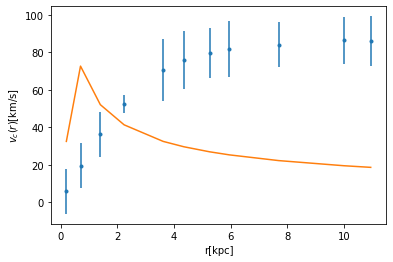

In [19]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,m_a_,np.asscalar(np.exp(LS_eps_ESO3020120.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [20]:
def Chi2_m_a_ESO3020120(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_ESO3020120,m_a,eps_,l=1.)
    xi = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [21]:
x0_m_a_ESO3020120 = np.array(np.log(1.0e-23))
LS_m_a_ESO3020120 = optimize.minimize(Chi2_m_a_ESO3020120,x0_m_a_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a_ESO3020120)

      fun: 44.392371467061935
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-52.46626756])


In [22]:
print(np.exp(LS_m_a_ESO3020120.x))

[1.63753093e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

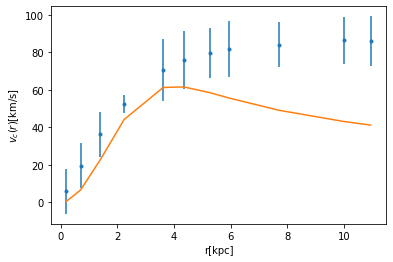

In [23]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_ESO3020120.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [25]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    return Vc_xi2(r,m_a,eps,l=1.)

In [27]:
def Xi2_m_a_eps_ESO3020120(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO3020120,par)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [28]:
x0_m_a_eps_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO3020120 = optimize.minimize(Xi2_m_a_eps_ESO3020120,x0_m_a_eps_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_ESO3020120)

      fun: 8.60753201763043
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00033218, 0.00056559])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([-53.08461864,  -7.88531665])


In [29]:
print(np.exp(LS_m_a_eps_ESO3020120.x))

[8.82354392e-24 3.76227460e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 1.0, '$m_{a}$=8.823543924447775e-24$\\epsilon$=0.0003762274604582216')

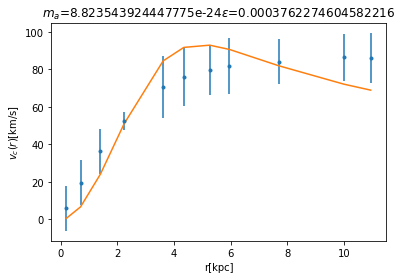

In [31]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_ESO3020120.x[1])))

# ESO3050090

In [32]:
ESO3050090 = np.loadtxt(path+'ESO3050090.dat')

In [33]:
vecRp_ESO3050090 = np.array([row[1] for row in ESO3050090])# galactocentric distance [kpc]
vecvRp_ESO3050090 = np.array([row[5] for row in ESO3050090])# rotation velocity [km/s]
vecerrvRp_ESO3050090 = np.array([row[6] for row in ESO3050090])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

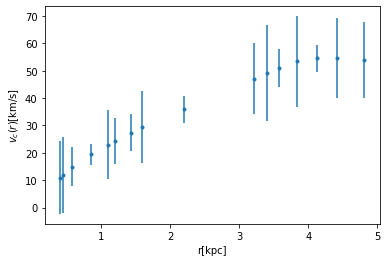

In [34]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [35]:
def Xi2_m_a_eps_ESO3050090(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO3050090,par)
    xi  = np.sum((vecvRp_ESO3050090-model)**2./(vecerrvRp_ESO3050090)**2.)
    return xi

In [36]:
x0_m_a_eps_ESO3050090 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO3050090 = optimize.minimize(Xi2_m_a_eps_ESO3050090,x0_m_a_eps_ESO3050090,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_ESO3050090)

      fun: 11.112756132424508
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.89226397e-05, 4.97379874e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 11
     njev: 17
   status: 0
  success: True
        x: array([-52.11804376,  -8.4532485 ])


In [37]:
print(np.exp(LS_m_a_eps_ESO3050090.x))

[2.31964320e-23 2.13206686e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

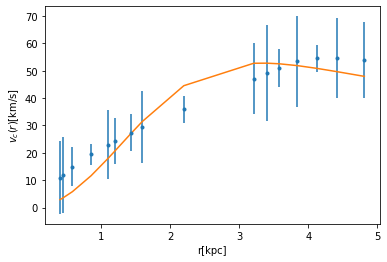

In [39]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps_ESO3050090.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3050090.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# ESO4880049

In [40]:
ESO4880049 = np.loadtxt(path+'ESO4880049.dat')

In [41]:
vecRp_ESO4880049 = np.array([row[1] for row in ESO4880049])# galactocentric distance [kpc]
vecvRp_ESO4880049 = np.array([row[5] for row in ESO4880049])# rotation velocity [km/s]
vecerrvRp_ESO4880049 = np.array([row[6] for row in ESO4880049])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

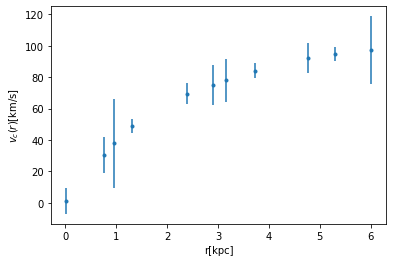

In [42]:
plt.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [43]:
def Xi2_m_a_eps_ESO4880049(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO4880049,par)
    xi  = np.sum((vecvRp_ESO4880049-model)**2./(vecerrvRp_ESO4880049)**2.)
    return xi

In [44]:
x0_m_a_eps_ESO4880049 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO4880049 = optimize.minimize(Xi2_m_a_eps_ESO4880049,x0_m_a_eps_ESO4880049,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_ESO4880049)

      fun: 348.8342342611341
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.1388713 , 4.17015829])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 12
     njev: 56
   status: 0
  success: True
        x: array([-50.73412104,  -7.19987711])


In [45]:
print(np.exp(LS_m_a_eps_ESO4880049.x))

[9.25659342e-23 7.46677562e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

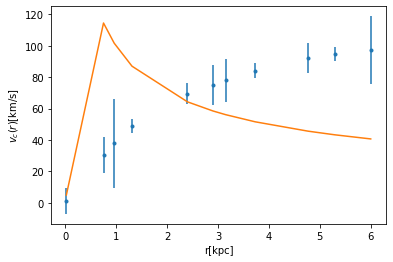

In [46]:
plt.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
plt.plot(vecRp_ESO4880049,Vc_xi2(vecRp_ESO4880049,np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# U11557

In [47]:
U11557 = np.loadtxt(path+'U11557.dat')

In [48]:
vecRp_U11557 = np.array([row[1] for row in U11557])# galactocentric distance [kpc]
vecvRp_U11557 = np.array([row[5] for row in U11557])# rotation velocity [km/s]
vecerrvRp_U11557 = np.array([row[6] for row in U11557])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

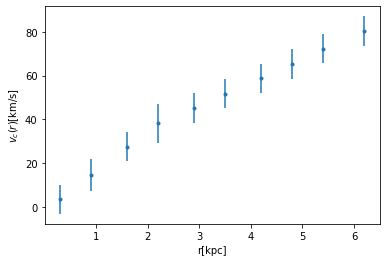

In [49]:
plt.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [50]:
def Xi2_m_a_eps_U11557(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U11557,par)
    xi  = np.sum((vecvRp_U11557-model)**2./(vecerrvRp_U11557)**2.)
    return xi

In [51]:
x0_m_a_eps_U11557 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U11557 = optimize.minimize(Xi2_m_a_eps_U11557,x0_m_a_eps_U11557,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U11557)

      fun: 7.611589212525327
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.76996181e-07, 1.24344968e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([-53.02543498,  -8.12737282])


In [52]:
print(np.exp(LS_m_a_eps_U11557.x))

[9.36151609e-24 2.95343101e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

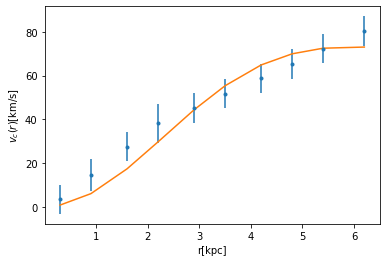

In [53]:
plt.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
plt.plot(vecRp_U11557,Vc_xi2(vecRp_U11557,np.asscalar(np.exp(LS_m_a_eps_U11557.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11557.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# U11616

In [54]:
U11616 = np.loadtxt(path+'U11616.dat')

In [55]:
vecRp_U11616 = np.array([row[1] for row in U11616])# galactocentric distance [kpc]
vecvRp_U11616 = np.array([row[5] for row in U11616])# rotation velocity [km/s]
vecerrvRp_U11616 = np.array([row[6] for row in U11616])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

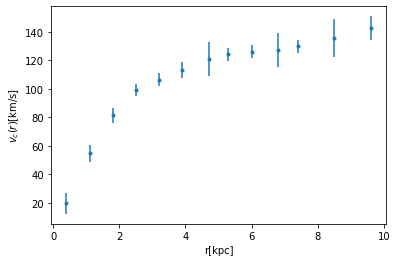

In [56]:
plt.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [57]:
def Xi2_m_a_eps_U11616(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U11616,par)
    xi  = np.sum((vecvRp_U11616-model)**2./(vecerrvRp_U11616)**2.)
    return xi

In [58]:
x0_m_a_eps_U11616 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U11616 = optimize.minimize(Xi2_m_a_eps_U11616,x0_m_a_eps_U11616,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U11616)

      fun: 105.96731423096827
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01053451, -0.01049898])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 13
     njev: 21
   status: 0
  success: True
        x: array([-53.37878922,  -7.50777952])


In [59]:
print(np.exp(LS_m_a_eps_U11616.x))

[6.57485822e-24 5.48798331e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

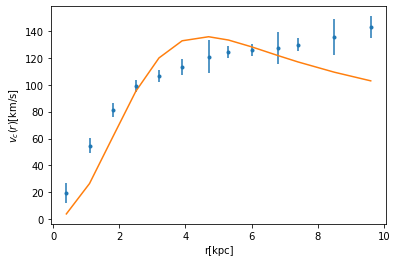

In [60]:
plt.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
plt.plot(vecRp_U11616,Vc_xi2(vecRp_U11616,np.asscalar(np.exp(LS_m_a_eps_U11616.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11616.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# U4115

In [61]:
U4115 = np.loadtxt(path+'U4115.dat')

In [62]:
vecRp_U4115 = np.array([row[1] for row in U4115])# galactocentric distance [kpc]
vecvRp_U4115 = np.array([row[5] for row in U4115])# rotation velocity [km/s]
vecerrvRp_U4115 = np.array([row[6] for row in U4115])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

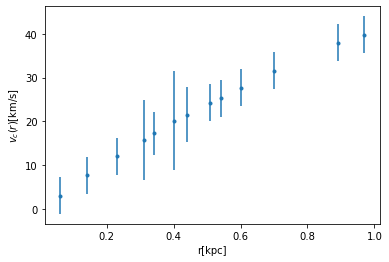

In [63]:
plt.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [64]:
def Xi2_m_a_eps_U4115(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U4115,par)
    xi  = np.sum((vecvRp_U4115-model)**2./(vecerrvRp_U4115)**2.)
    return xi

In [65]:
x0_m_a_eps_U4115 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U4115 = optimize.minimize(Xi2_m_a_eps_U4115,x0_m_a_eps_U4115,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U4115)

      fun: 5.082831697912227
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.63143947e+00,  1.77635669e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 10
     njev: 20
   status: 0
  success: True
        x: array([-50.65687205,  -8.74339126])


In [66]:
print(np.exp(LS_m_a_eps_U4115.x))

[1.00000000e-22 1.59512023e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

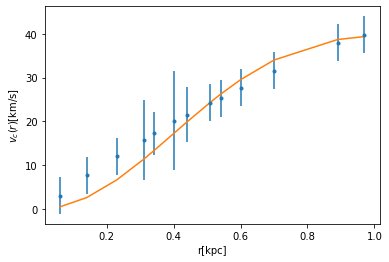

In [67]:
plt.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
plt.plot(vecRp_U4115,Vc_xi2(vecRp_U4115,np.asscalar(np.exp(LS_m_a_eps_U4115.x[0])),np.asscalar(np.exp(LS_m_a_eps_U4115.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Subplots

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if sys.path[0] == '':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since

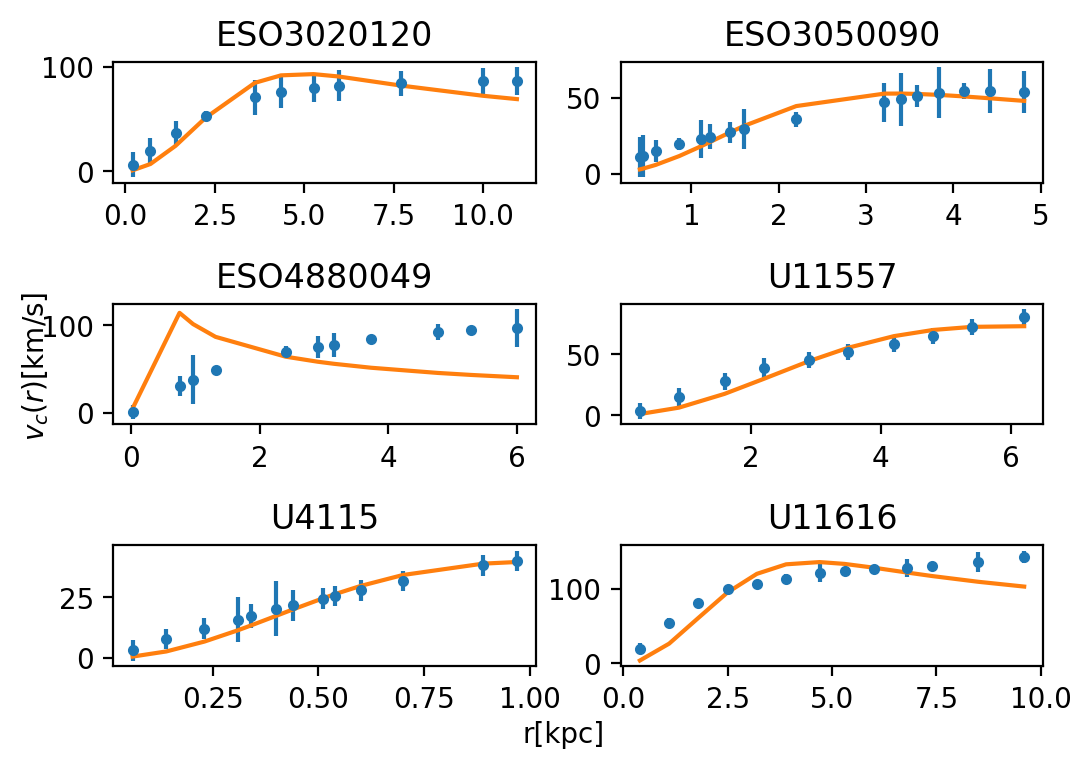

In [70]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3,ncols=2,dpi=200)
ax0.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
ax0.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1]))))
ax0.set_title('ESO3020120')
ax1.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
ax1.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps_ESO3050090.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3050090.x[1]))))
ax1.set_title('ESO3050090')
ax2.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
ax2.plot(vecRp_ESO4880049,Vc_xi2(vecRp_ESO4880049,np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[1]))))
ax2.set_title('ESO4880049')
ax3.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
ax3.plot(vecRp_U11557,Vc_xi2(vecRp_U11557,np.asscalar(np.exp(LS_m_a_eps_U11557.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11557.x[1]))))
ax3.set_title('U11557')
ax4.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
ax4.plot(vecRp_U4115,Vc_xi2(vecRp_U4115,np.asscalar(np.exp(LS_m_a_eps_U4115.x[0])),np.asscalar(np.exp(LS_m_a_eps_U4115.x[1]))))
ax4.set_title('U4115')
ax5.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
ax5.plot(vecRp_U11616,Vc_xi2(vecRp_U11616,np.asscalar(np.exp(LS_m_a_eps_U11616.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11616.x[1]))))
ax5.set_title('U11616')
# Set common labels
fig.text(0.5, 0.04, 'r[kpc]', ha='center', va='center')
fig.text(0.06, 0.5, r'$v_{c}(r)$[km/s]', ha='center', va='center', rotation='vertical')
plt.subplots_adjust(hspace=1.)